In [1]:
from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [3]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [6]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y


#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


"""def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)"""



def weighted_binary_crossentropy(y_true, y_pred):
        # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70
    weighted_b_ce = weight_vector * b_ce

        # Return the mean error
    return K.mean(weighted_b_ce)


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)


#Override Dropout. Make it able at test time.
def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [7]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(0.5)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.5)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(0.5)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model



## Constants

In [33]:
data_path = '../data/'

path_img_train = data_path + 'images_69.npy'
path_mask_train = data_path + 'masks_69.npy'

path_img_valid = data_path + 'images_valid_29.npy'
path_mask_valid = data_path + 'masks_valid_29.npy'

# PATH definition
initial_weights_path = "./models/initial_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"


# image dimension (array)
img_rows = 512
img_cols = 512

batch_size = 14



fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.1
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

nb_initial_epochs = 700
apply_augmentation = True
nb_step_predictions = 20

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs


apply_edt = False



### Data pre processing

In [25]:
X_train, y_train = load_data(path_img_train, path_mask_train, img_rows, img_cols )
print("*************Xtrain.shape***********", y_train.shape)


X_valid, y_valid = load_data(path_img_valid, path_mask_valid, img_rows, img_cols)
print("*************Xvalid.shape***********", X_valid.shape)

X_valid = X_valid[:-2]
y_valid = y_valid[:-2]

X_test = X_valid[-2:]
y_test = y_valid[-2:]

print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)
print(X_test.shape)



Loading data...

*************Xtrain.shape*********** (69, 1, 512, 512)

Loading data...

*************Xvalid.shape*********** (29, 1, 512, 512)
(27, 1, 512, 512) (27, 1, 512, 512) (2, 1, 512, 512) (2, 1, 512, 512)
(2, 1, 512, 512)


### Data Augmentation

In [29]:
# data augmentation
seed = 1

train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)

train_generator = zip(train_img_generator, train_mask_generator)



## Training

In [34]:
model = unet_full_bn(dropout = True)
reset_weights(model)
print(model.summary())

model_checkpoint = ModelCheckpoint(initial_weights_path, monitor='loss', save_best_only = True)


# if Data Augmentation
if apply_augmentation:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit_generator(train_generator, 
                                  validation_data = (X_valid, y_valid),
                                  epochs = nb_initial_epochs, 
                                  verbose = 1,
                                  shuffle = True,
                                  steps_per_epoch=10, 
                                  #validation_steps= 5,
                                  callbacks = [tensorboard])
    model.save(final_weights_path)

    
# if No Data Augmentation
else:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                            batch_size = batch_size, 
                            epochs = nb_initial_epochs,
                            verbose = 1, 
                            shuffle = True, 
                            callbacks = [tensorboard])
    model.save(final_weights_path)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 32, 512, 512) 320         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 32, 512, 512) 9248        conv2d_134[0][0]                 
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 512, 512) 128         conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_poolin

Epoch 1/700
10/10 [==============================] - 9s 878ms/step - loss: 0.3277 - dice_coef: 0.5566 - val_loss: 1.2132 - val_dice_coef: 0.1886
Epoch 2/700
10/10 [==============================] - 7s 732ms/step - loss: 0.2589 - dice_coef: 0.6372 - val_loss: 0.2578 - val_dice_coef: 0.5747
Epoch 3/700
10/10 [==============================] - 7s 730ms/step - loss: 0.2419 - dice_coef: 0.6484 - val_loss: 0.4205 - val_dice_coef: 0.1786
Epoch 4/700
10/10 [==============================] - 7s 728ms/step - loss: 0.2358 - dice_coef: 0.6450 - val_loss: 0.4729 - val_dice_coef: 0.1378
Epoch 5/700
10/10 [==============================] - 7s 731ms/step - loss: 0.2274 - dice_coef: 0.6495 - val_loss: 0.2083 - val_dice_coef: 0.3664
Epoch 6/700
10/10 [==============================] - 7s 729ms/step - loss: 0.2195 - dice_coef: 0.6509 - val_loss: 0.1771 - val_dice_coef: 0.4850
Epoch 7/700
10/10 [==============================] - 7s 731ms/step - loss: 0.2161 - dice_coef: 0.6483 - val_loss: 0.1999 - val_dic

10/10 [==============================] - 7s 733ms/step - loss: 0.1624 - dice_coef: 0.7252 - val_loss: 0.1863 - val_dice_coef: 0.6796
Epoch 58/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1548 - dice_coef: 0.7264 - val_loss: 0.1891 - val_dice_coef: 0.6772
Epoch 59/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1597 - dice_coef: 0.7281 - val_loss: 0.1847 - val_dice_coef: 0.6840
Epoch 60/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1626 - dice_coef: 0.7221 - val_loss: 0.1750 - val_dice_coef: 0.6786
Epoch 61/700
10/10 [==============================] - 7s 736ms/step - loss: 0.1637 - dice_coef: 0.7267 - val_loss: 0.1782 - val_dice_coef: 0.6642
Epoch 62/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1620 - dice_coef: 0.7257 - val_loss: 0.1739 - val_dice_coef: 0.6699
Epoch 63/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1597 - dice_coef: 0.7294 - val_loss: 0.1925 - val_dice_coef

10/10 [==============================] - 7s 734ms/step - loss: 0.1306 - dice_coef: 0.7904 - val_loss: 0.1769 - val_dice_coef: 0.6993
Epoch 114/700
10/10 [==============================] - 7s 733ms/step - loss: 0.1296 - dice_coef: 0.7970 - val_loss: 0.1688 - val_dice_coef: 0.6956
Epoch 115/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1347 - dice_coef: 0.7925 - val_loss: 0.1631 - val_dice_coef: 0.6903
Epoch 116/700
10/10 [==============================] - 7s 737ms/step - loss: 0.1305 - dice_coef: 0.7923 - val_loss: 0.1729 - val_dice_coef: 0.6960
Epoch 117/700
10/10 [==============================] - 7s 733ms/step - loss: 0.1301 - dice_coef: 0.7959 - val_loss: 0.1651 - val_dice_coef: 0.6840
Epoch 118/700
10/10 [==============================] - 7s 733ms/step - loss: 0.1338 - dice_coef: 0.7942 - val_loss: 0.1592 - val_dice_coef: 0.6918
Epoch 119/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1295 - dice_coef: 0.7976 - val_loss: 0.1863 - val_dic

Epoch 169/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1156 - dice_coef: 0.8224 - val_loss: 0.1731 - val_dice_coef: 0.7050
Epoch 170/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1187 - dice_coef: 0.8216 - val_loss: 0.1632 - val_dice_coef: 0.6963
Epoch 171/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1235 - dice_coef: 0.8168 - val_loss: 0.1784 - val_dice_coef: 0.7049
Epoch 172/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1190 - dice_coef: 0.8209 - val_loss: 0.1673 - val_dice_coef: 0.6960
Epoch 173/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1158 - dice_coef: 0.8224 - val_loss: 0.1748 - val_dice_coef: 0.7150
Epoch 174/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1189 - dice_coef: 0.8194 - val_loss: 0.1890 - val_dice_coef: 0.7084
Epoch 175/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1211 - dice_coef: 0.8222 - val_loss: 0.

Epoch 225/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1189 - dice_coef: 0.8306 - val_loss: 0.1861 - val_dice_coef: 0.6906
Epoch 226/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1146 - dice_coef: 0.8320 - val_loss: 0.1789 - val_dice_coef: 0.7197
Epoch 227/700
10/10 [==============================] - 7s 733ms/step - loss: 0.1105 - dice_coef: 0.8375 - val_loss: 0.1854 - val_dice_coef: 0.7186
Epoch 228/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1102 - dice_coef: 0.8375 - val_loss: 0.1862 - val_dice_coef: 0.7169
Epoch 229/700
10/10 [==============================] - 7s 734ms/step - loss: 0.1136 - dice_coef: 0.8360 - val_loss: 0.1829 - val_dice_coef: 0.7097
Epoch 230/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1123 - dice_coef: 0.8358 - val_loss: 0.1774 - val_dice_coef: 0.7061
Epoch 231/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1120 - dice_coef: 0.8373 - val_loss: 0.

Epoch 281/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1082 - dice_coef: 0.8431 - val_loss: 0.1953 - val_dice_coef: 0.7109
Epoch 282/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1090 - dice_coef: 0.8428 - val_loss: 0.1870 - val_dice_coef: 0.7115
Epoch 283/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1071 - dice_coef: 0.8429 - val_loss: 0.1827 - val_dice_coef: 0.7183
Epoch 284/700
10/10 [==============================] - 7s 729ms/step - loss: 0.1105 - dice_coef: 0.8396 - val_loss: 0.1721 - val_dice_coef: 0.6953
Epoch 285/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1116 - dice_coef: 0.8445 - val_loss: 0.1860 - val_dice_coef: 0.7070
Epoch 286/700
10/10 [==============================] - 7s 728ms/step - loss: 0.1144 - dice_coef: 0.8375 - val_loss: 0.1760 - val_dice_coef: 0.6935
Epoch 287/700
10/10 [==============================] - 7s 735ms/step - loss: 0.1041 - dice_coef: 0.8450 - val_loss: 0.

Epoch 337/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1072 - dice_coef: 0.8476 - val_loss: 0.1809 - val_dice_coef: 0.7144
Epoch 338/700
10/10 [==============================] - 7s 733ms/step - loss: 0.1061 - dice_coef: 0.8482 - val_loss: 0.1884 - val_dice_coef: 0.7037
Epoch 339/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1091 - dice_coef: 0.8456 - val_loss: 0.1789 - val_dice_coef: 0.6844
Epoch 340/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1075 - dice_coef: 0.8472 - val_loss: 0.1936 - val_dice_coef: 0.7165
Epoch 341/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1098 - dice_coef: 0.8466 - val_loss: 0.1867 - val_dice_coef: 0.7119
Epoch 342/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1044 - dice_coef: 0.8464 - val_loss: 0.1868 - val_dice_coef: 0.7132
Epoch 343/700
10/10 [==============================] - 7s 734ms/step - loss: 0.1079 - dice_coef: 0.8481 - val_loss: 0.

Epoch 393/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1043 - dice_coef: 0.8528 - val_loss: 0.1968 - val_dice_coef: 0.7170
Epoch 394/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1091 - dice_coef: 0.8504 - val_loss: 0.1884 - val_dice_coef: 0.7151
Epoch 395/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1022 - dice_coef: 0.8539 - val_loss: 0.1929 - val_dice_coef: 0.6927
Epoch 396/700
10/10 [==============================] - 7s 734ms/step - loss: 0.1056 - dice_coef: 0.8528 - val_loss: 0.1921 - val_dice_coef: 0.7215
Epoch 397/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1023 - dice_coef: 0.8555 - val_loss: 0.1938 - val_dice_coef: 0.7046
Epoch 398/700
10/10 [==============================] - 7s 732ms/step - loss: 0.0992 - dice_coef: 0.8582 - val_loss: 0.1886 - val_dice_coef: 0.7126
Epoch 399/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1023 - dice_coef: 0.8579 - val_loss: 0.

Epoch 449/700
10/10 [==============================] - 7s 733ms/step - loss: 0.0972 - dice_coef: 0.8644 - val_loss: 0.1936 - val_dice_coef: 0.7154
Epoch 450/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1021 - dice_coef: 0.8551 - val_loss: 0.1897 - val_dice_coef: 0.7106
Epoch 451/700
10/10 [==============================] - 7s 731ms/step - loss: 0.0986 - dice_coef: 0.8602 - val_loss: 0.1894 - val_dice_coef: 0.7124
Epoch 452/700
10/10 [==============================] - 7s 733ms/step - loss: 0.1050 - dice_coef: 0.8566 - val_loss: 0.1912 - val_dice_coef: 0.7138
Epoch 453/700
10/10 [==============================] - 7s 733ms/step - loss: 0.1055 - dice_coef: 0.8515 - val_loss: 0.1879 - val_dice_coef: 0.7096
Epoch 454/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1047 - dice_coef: 0.8530 - val_loss: 0.1978 - val_dice_coef: 0.6936
Epoch 455/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1047 - dice_coef: 0.8571 - val_loss: 0.

Epoch 505/700
10/10 [==============================] - 7s 733ms/step - loss: 0.0990 - dice_coef: 0.8619 - val_loss: 0.1910 - val_dice_coef: 0.7123
Epoch 506/700
10/10 [==============================] - 7s 733ms/step - loss: 0.0994 - dice_coef: 0.8596 - val_loss: 0.1979 - val_dice_coef: 0.7059
Epoch 507/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1026 - dice_coef: 0.8570 - val_loss: 0.2105 - val_dice_coef: 0.7284
Epoch 508/700
10/10 [==============================] - 7s 728ms/step - loss: 0.0981 - dice_coef: 0.8592 - val_loss: 0.1895 - val_dice_coef: 0.7225
Epoch 509/700
10/10 [==============================] - 7s 734ms/step - loss: 0.0999 - dice_coef: 0.8611 - val_loss: 0.2001 - val_dice_coef: 0.6962
Epoch 510/700
10/10 [==============================] - 7s 729ms/step - loss: 0.0966 - dice_coef: 0.8602 - val_loss: 0.2041 - val_dice_coef: 0.7264
Epoch 511/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1012 - dice_coef: 0.8591 - val_loss: 0.

Epoch 561/700
10/10 [==============================] - 7s 729ms/step - loss: 0.0949 - dice_coef: 0.8652 - val_loss: 0.1961 - val_dice_coef: 0.7066
Epoch 562/700
10/10 [==============================] - 7s 729ms/step - loss: 0.0971 - dice_coef: 0.8633 - val_loss: 0.2003 - val_dice_coef: 0.7205
Epoch 563/700
10/10 [==============================] - 7s 733ms/step - loss: 0.0960 - dice_coef: 0.8644 - val_loss: 0.2057 - val_dice_coef: 0.7160
Epoch 564/700
10/10 [==============================] - 7s 731ms/step - loss: 0.0971 - dice_coef: 0.8618 - val_loss: 0.2019 - val_dice_coef: 0.6995
Epoch 565/700
10/10 [==============================] - 7s 732ms/step - loss: 0.0979 - dice_coef: 0.8619 - val_loss: 0.2041 - val_dice_coef: 0.7269
Epoch 566/700
10/10 [==============================] - 7s 730ms/step - loss: 0.1010 - dice_coef: 0.8598 - val_loss: 0.2055 - val_dice_coef: 0.7213
Epoch 567/700
10/10 [==============================] - 7s 731ms/step - loss: 0.0981 - dice_coef: 0.8592 - val_loss: 0.

Epoch 617/700
10/10 [==============================] - 7s 731ms/step - loss: 0.0984 - dice_coef: 0.8634 - val_loss: 0.2107 - val_dice_coef: 0.7194
Epoch 618/700
10/10 [==============================] - 7s 736ms/step - loss: 0.0965 - dice_coef: 0.8643 - val_loss: 0.2011 - val_dice_coef: 0.7160
Epoch 619/700
10/10 [==============================] - 7s 733ms/step - loss: 0.0973 - dice_coef: 0.8651 - val_loss: 0.2131 - val_dice_coef: 0.7215
Epoch 620/700
10/10 [==============================] - 7s 732ms/step - loss: 0.0993 - dice_coef: 0.8643 - val_loss: 0.2019 - val_dice_coef: 0.7079
Epoch 621/700
10/10 [==============================] - 7s 731ms/step - loss: 0.0976 - dice_coef: 0.8617 - val_loss: 0.1981 - val_dice_coef: 0.7189
Epoch 622/700
10/10 [==============================] - 7s 734ms/step - loss: 0.0955 - dice_coef: 0.8682 - val_loss: 0.2036 - val_dice_coef: 0.7223
Epoch 623/700
10/10 [==============================] - 7s 730ms/step - loss: 0.0980 - dice_coef: 0.8636 - val_loss: 0.

Epoch 673/700
10/10 [==============================] - 7s 731ms/step - loss: 0.1006 - dice_coef: 0.8611 - val_loss: 0.2068 - val_dice_coef: 0.7170
Epoch 674/700
10/10 [==============================] - 7s 731ms/step - loss: 0.0947 - dice_coef: 0.8681 - val_loss: 0.2097 - val_dice_coef: 0.7171
Epoch 675/700
10/10 [==============================] - 7s 732ms/step - loss: 0.0934 - dice_coef: 0.8704 - val_loss: 0.2148 - val_dice_coef: 0.7176
Epoch 676/700
10/10 [==============================] - 7s 731ms/step - loss: 0.0954 - dice_coef: 0.8696 - val_loss: 0.2155 - val_dice_coef: 0.7155
Epoch 677/700
10/10 [==============================] - 7s 728ms/step - loss: 0.1007 - dice_coef: 0.8655 - val_loss: 0.2019 - val_dice_coef: 0.7202
Epoch 678/700
10/10 [==============================] - 7s 730ms/step - loss: 0.0924 - dice_coef: 0.8679 - val_loss: 0.2155 - val_dice_coef: 0.7268
Epoch 679/700
10/10 [==============================] - 7s 732ms/step - loss: 0.1003 - dice_coef: 0.8647 - val_loss: 0.

In [12]:
print("Saving model...\n")   
model.save(final_weights_path)

Saving model...



## Predict and Compute Uncertainty Map

In [13]:
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

In [14]:
# Predictions

print("Computing log predictions ...\n")
predictions = predict(X_test, model)
print(len(predictions))
sample_prediction = cv2.threshold(predictions[0], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
sample_prediction.shape

Computing log predictions ...

2


(1, 512, 512)

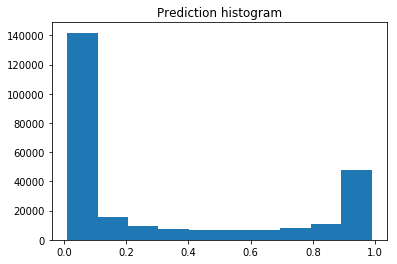

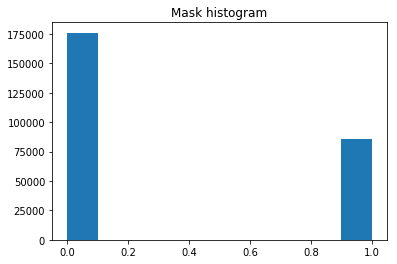

In [15]:
plt.hist(predictions[0].flatten())
plt.title("Prediction histogram")
plt.show()
plt.hist(y_test[0].flatten())
plt.title("Mask histogram")
plt.show()


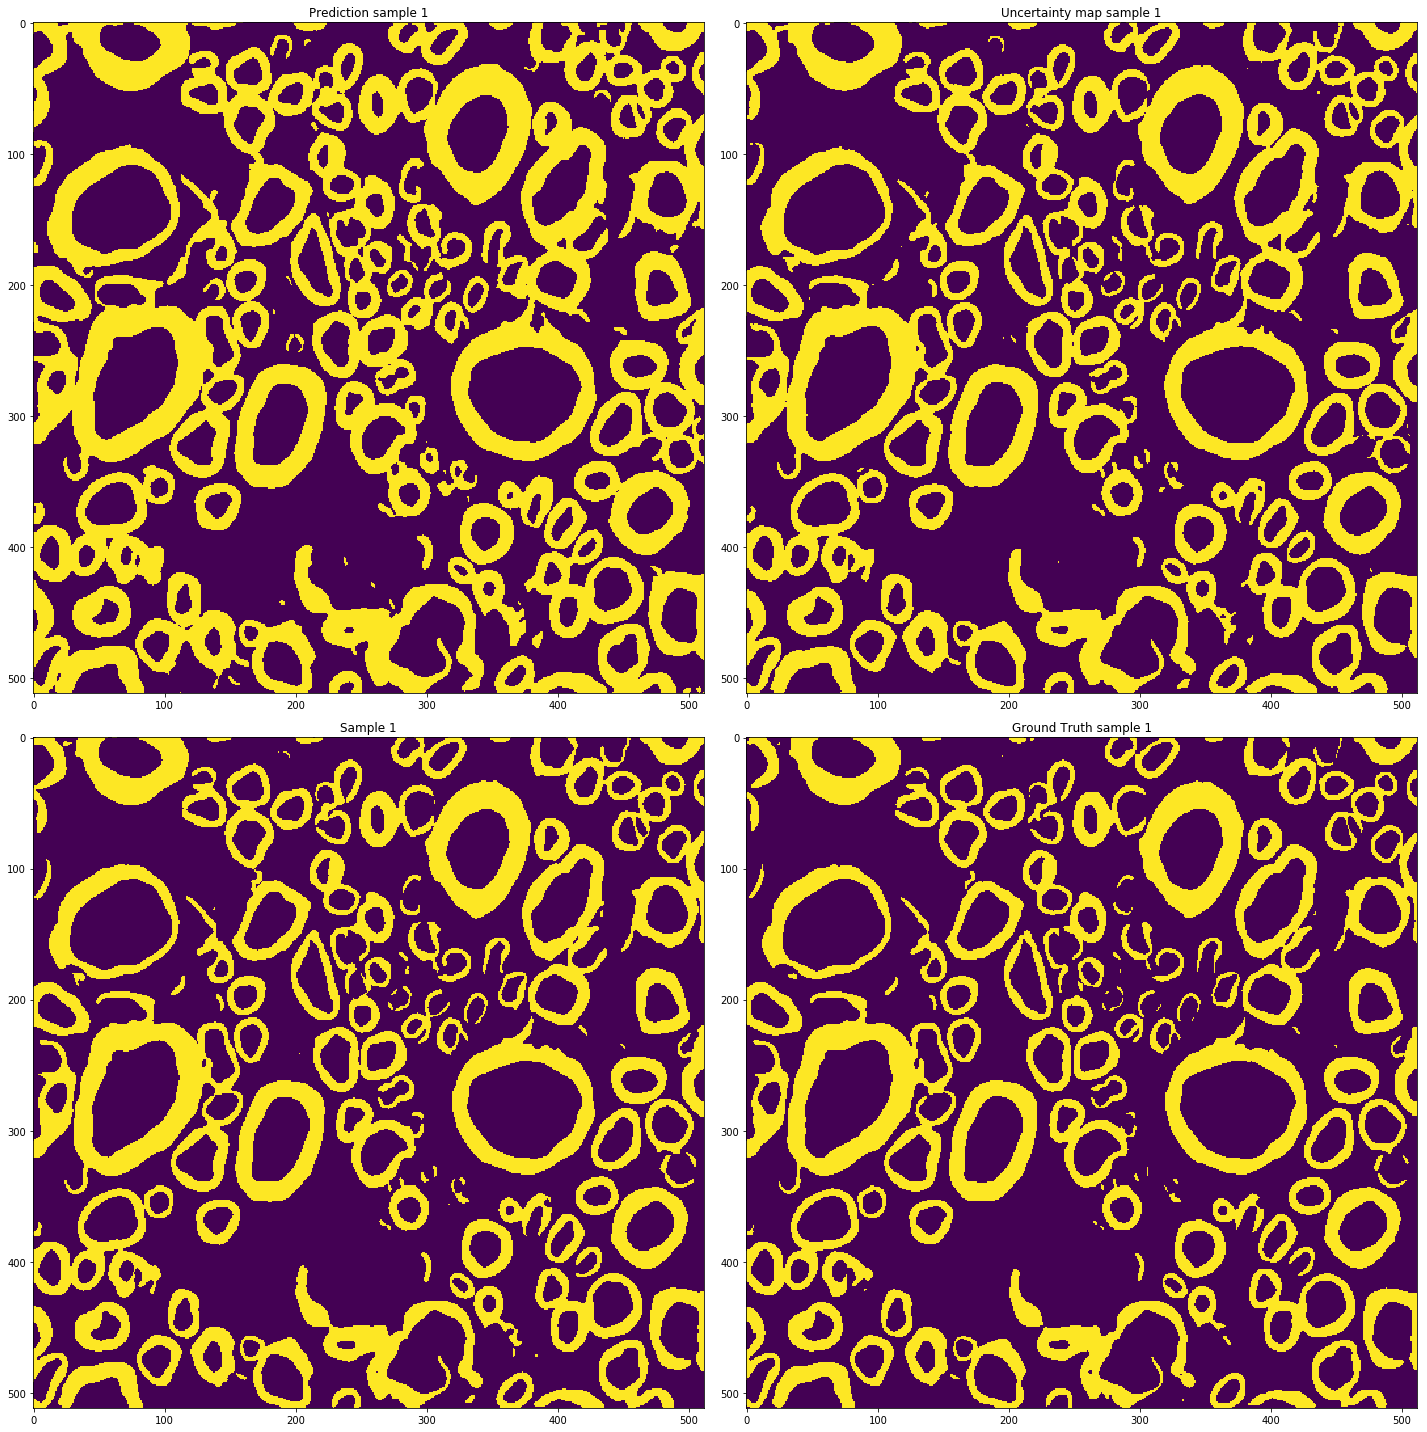

In [16]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.2, 1, cv2.THRESH_BINARY)[1])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.4, 1, cv2.THRESH_BINARY)[1])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.5, 1, cv2.THRESH_BINARY)[1])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.6, 1, cv2.THRESH_BINARY)[1])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

In [35]:
# uncertainty computation

weights = final_weights_path
modelUncertain = unet_full_bn(dropout = True)
modelUncertain.load_weights(weights)

uncertain_map = []
uncertain = np.zeros(len(X_test))
accuracy = np.zeros(len(X_test))

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for i in range(len(X_test)):
    sample = X_test[i].reshape([1, 1, img_rows, img_cols])
    sample_prediction = cv2.threshold(predictions[i], 0.99, 1, cv2.THRESH_BINARY)[1].astype('uint8')
    accuracy[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
    uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
    uncertain_map.append(uncertain_map_i)
    
    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

Computing log predictions ...

(2, 512, 512)
Done


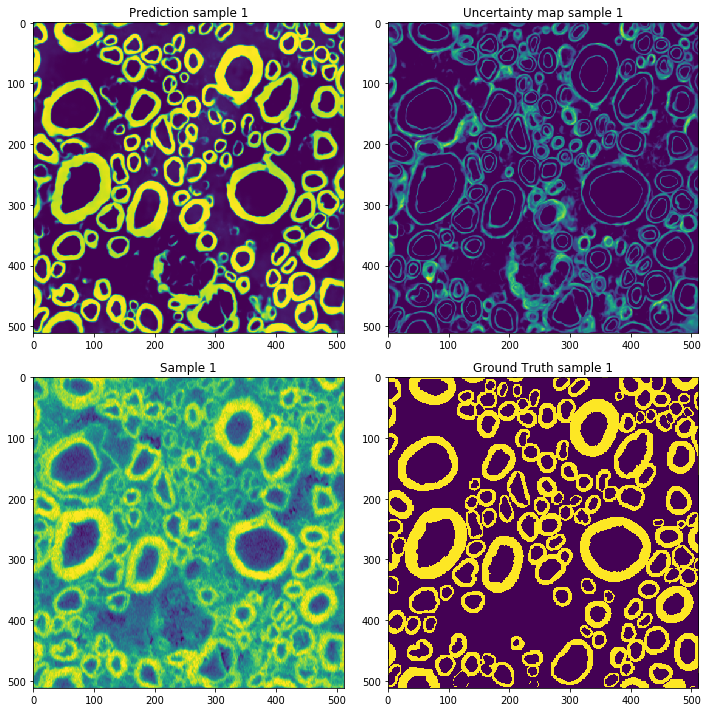

In [36]:
# Plot predictions and uncertainty map for 2 samples 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions[0][0,:,:])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(uncertain_map_array[0])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(X_test[0][0,:,:])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(y_test[0][0,:,:])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

In [ ]:
X = np.load(path_mask_train)[0]
X.shape
plt.imshow(X[0, :, :], cmap = 'gray')
plt.show()
X

In [ ]:
np.min(X)